# SPARSE application example

This notebook contains an application of the SPARSE module to a relatively simple system of two coupled potentials.

# Introduction

### Import

**IMPORTANT:** To successfully load the SPARSE module, there need to be two files inside the working directory called *channels.csv* and *potential.csv*.

The module comes with a script which generates the files used for this notebook. Let us run it:

In [1]:
runfile('example_potential.py')

writing channels... 
writing potential... 


It is preferable to load the module via an import statement.
Running the file sparse.py in an open IPython console also works, but will disable some multiprocessing features.

In [2]:
from sparse import *

Note that loading sparse with a star import also imports NumPy as **np** and Pandas as **pd**.

In [3]:
from utils import poles, amplitudes, composition

The utils module contains useful functions to analyze the results of the SPARSE algorithm:

*poles:* calculates the scattering poles by extrapolating an input *K*-matrix to complex energies.

*amplitudes:* calculates the scattering amplitudes for real energies from an input *K*-matrix.

*composition:* calculates the probabilities of a bound state from an input reduced radial wave function.

### Setup

The potential metadata is loaded from a csv file called *channels.csv* and stored in a global Pandas DataFrame called **channels**. Let us have a look at the channels in this example:

In [4]:
channels

,channel,l,threshold,mu
1,Lower (P-wave),1,0.0,1000.0
2,Higher (S-wave),0,100.0,1000.0


The potential itself is loaded from a csv file called *potential.csv* and stored in a global Pandas DataFrame called **potential**. Observe that each row of the DataFrame contains the flattened potential matrix at a given position.

In [5]:
potential.head()

row                      1                           2              
column                   1             2             1             2
9.999990e-07  1.000052e+09  4.999990e-07  4.999990e-07  50000.049501
1.999998e-06  2.500254e+08  1.999996e-06  1.999996e-06  25000.024004
2.999997e-06  1.111279e+08  4.499991e-06  4.499991e-06  16666.681842
3.999996e-06  6.251253e+07  7.999983e-06  7.999983e-06  12500.010516
4.999995e-06  4.000998e+07  1.249997e-05  1.249997e-05  10000.007525

Let us plot the potential matrix. Note the coupling potential in the off-diagonal elements.

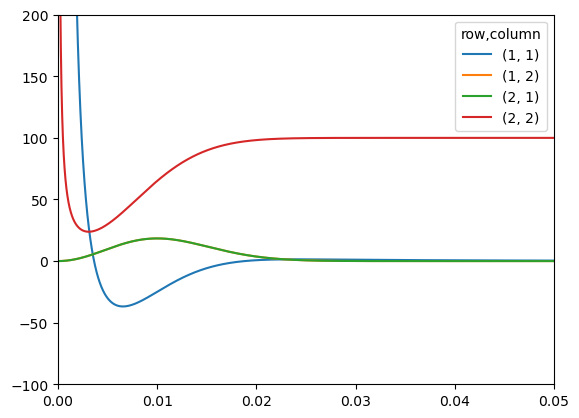

In [6]:
potential.plot(xlim=(0,0.05), ylim=(-100,200));

## Application

### Bound states

The SPARSE module is primarily designed for scattering states, but it also contains a handy bound state solver. Let us calculate the bound state energies and reduced radial wave functions in this potential matrix:

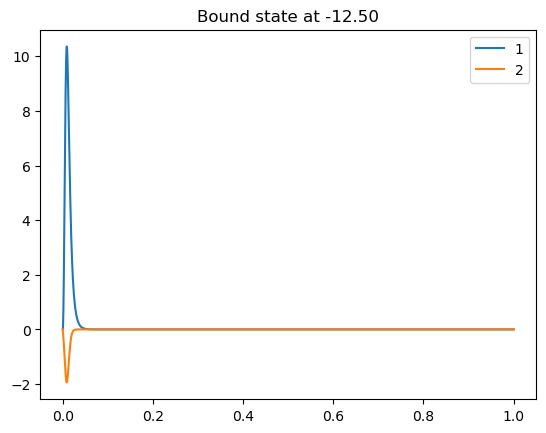

In [7]:
masses, reduced_radial_wave_functions = bound_states(1, -20)
for i, psi in enumerate(reduced_radial_wave_functions):
    psi.plot(title=f'Bound state at {masses[i]:.2f}')

Note the mixture between the two channels because of the couplings. Let us calculate the probabilities:

In [8]:
for i, psi in enumerate(reduced_radial_wave_functions):
    print(f'Probabilities for bound state at {masses[i]:.2f}')
    print(composition(psi))

Probabilities for bound state at -12.50
1    0.970417
2    0.029583
dtype: float64


## *K*-matrix

For a less trivial application, let us now calculate the *K*-matrix for energies above the threshold at 0.
For faster execution (at the expense of higher memory consuption), specify a number of parallel processes.
The number of parallel processes should not be larger than the number of cores on the machine executing the code.

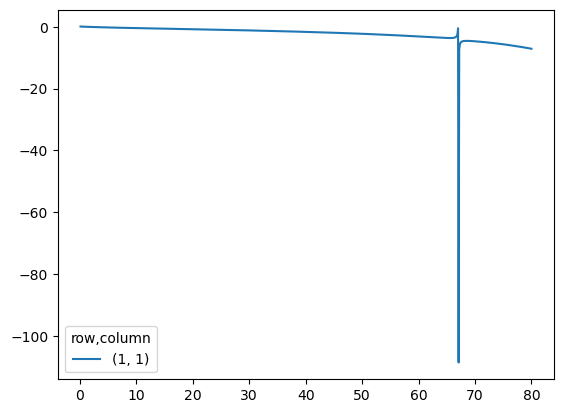

In [9]:
energies = np.linspace(0, 80, 801)
kmat = k_matrices(energies, processes=12)
kmat.plot();

The *K*-matrix completely determines the scattering problem. Let us use the amplitude function of the utils module to calculate the scattering amplitudes:

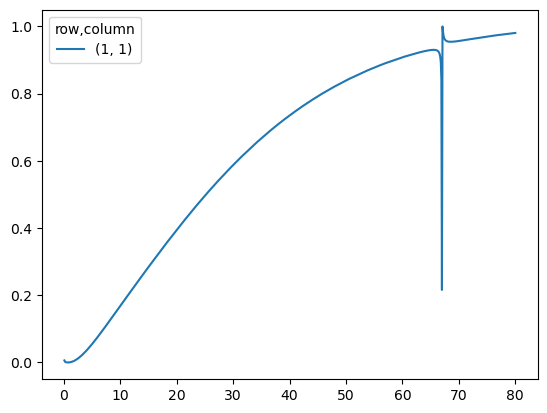

In [10]:
amps = amplitudes(kmat)
np.square(abs(amps)).plot();

Seems complicated! Note that the nonresonant background is expected because of the bound state near threshold. If we want to establish the pole structure of the signal near 70, we can use the pole extrapolation function defined in the utils module:

In [11]:
t_poles, k_poles = poles(kmat, rtol=1e-3, clean_up_tol=10)
print("Extrapolated T-matrix poles:")
print(t_poles)
print("For comparison, the K-matrix poles are:")
print(k_poles)

Extrapolated T-matrix poles:
[67.01713719-0.01942918j]
For comparison, the K-matrix poles are:
[67.09669499+4.1711177e-22j]


There is indeed a narrow pole on top of the nonresonant backround. The pole mass and width are respectively M=67.0 and Gamma=0.04.